In [1]:
import os

os.chdir("..")

In [2]:
from datasetsforecast.m3 import M3
from utilsforecast.plotting import plot_series
import pandas as pd
from models.NBeatsStackMoe import NBeatsStackMoe
from models.NBeatsMoeLags import NBeatsMoeLags
from neuralforecast import NeuralForecast
from utils import load_dataset, train_test_split
from models.callbacks.probs_collector import GateValuesCollectorCallback
from neuralforecast.losses.numpy import smape
from neuralforecast.models import NBEATS
from neuralforecast.tsdataset import TimeSeriesDataset
import matplotlib.pyplot as plt
from datasets.load_data.gluonts_dataset import GluontsDataset
from models.hyper import config
import numpy as np
import random
from neuralforecast.losses.pytorch import HuberLoss, MAE, MSE, SMAPE, MAPE, MASE
from functools import partial

# Load the M3 dataset
m3 = M3.load(directory='C:\\Users\\ricar\\mixture_of_experts_time_series\\data\\m3\\', group='Monthly')[0]


c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-01 20:53:45,450	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-06-01 20:53:45,639	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
horizon = 18

In [4]:
def calculate_smape(Y_test_df, Y_hat_df, forecast_col):
    """Calculate the sMAPE."""
    y_true = Y_test_df['y'].values
    try:
        y_hat = Y_hat_df[forecast_col].values
    except Exception as exc:
        y_hat = Y_hat_df
   
    n_series = Y_test_df['unique_id'].nunique()
    try:
        y_true = y_true.reshape(n_series, -1)
        y_hat = y_hat.reshape(n_series, -1)
    except Exception as e:
        raise ValueError("Error reshaping arrays") from e

    return smape(y_true, y_hat)

In [8]:
y_train, y_test = train_test_split(m3, horizon)
_t , y_val = train_test_split(y_train, horizon)
y_test

,unique_id,ds,y
0,M1,1994-03-31,2280.0
1,M1,1994-04-30,480.0
2,M1,1994-05-31,5040.0
3,M1,1994-06-30,1920.0
4,M1,1994-07-31,840.0
...,...,...,...
25699,M999,1993-10-31,5225.9
25700,M999,1993-11-30,5236.3
25701,M999,1993-12-31,5186.6
25702,M999,1994-01-31,5143.4


In [9]:
val_preds_on_ensemble_18_models = pd.read_csv('predictions_m3_nbeats_stack_moe_val_18.csv')
preds_on_ensemble_18 = pd.read_csv('predictions_m3_nbeats_stack_moe_18.csv')
preds_on_ensemble_18 = preds_on_ensemble_18.drop(columns=['prediction_agg'])
val_preds_on_ensemble_18_models = val_preds_on_ensemble_18_models.drop(columns=['prediction_agg'])

val_preds_on_ensemble_18_models['y'] = y_val['y'].values
val_preds_on_ensemble_18_models

,unique_id,ds,NBeatsStackMoe,NBeatsStackMoe1,NBeatsStackMoe2,NBeatsStackMoe3,NBeatsStackMoe4,NBeatsStackMoe5,NBeatsStackMoe6,NBeatsStackMoe7,...,NBeatsStackMoe9,NBeatsStackMoe10,NBeatsStackMoe11,NBeatsStackMoe12,NBeatsStackMoe13,NBeatsStackMoe14,NBeatsStackMoe15,NBeatsStackMoe16,NBeatsStackMoe17,y
0,M1,1992-09-30,3963.7890,2658.6956,3268.8276,4374.0864,3285.8740,2740.3862,4332.7230,2626.1282,...,5545.0103,3911.6821,3141.7856,2391.0073,2424.4550,4278.0150,3383.3987,3502.9350,2824.3928,6720.0
1,M1,1992-10-31,5095.4526,3283.7500,3347.9390,3634.2030,3806.8594,2534.0990,4432.4550,3679.2720,...,4834.1123,4568.1045,4342.5110,2728.1008,2376.9482,4364.2046,3679.3070,3475.8918,3015.0650,2040.0
2,M1,1992-11-30,4936.2110,3554.6455,3771.4023,3931.0085,3188.3438,3709.8503,4892.7150,2763.7173,...,4671.7010,4570.1045,5816.4260,2230.4595,2559.6543,4336.2104,4923.6807,3172.8690,2901.2815,6480.0
3,M1,1992-12-31,5008.3940,3131.2640,3643.9912,4377.4030,3148.4834,3053.1987,2716.7812,2297.1086,...,4741.8857,4085.8860,5320.5293,2480.0984,2457.8064,4447.3853,4327.8667,2590.8820,3013.7786,1920.0
4,M1,1993-01-31,3946.1968,3554.4758,3441.6270,3801.2024,2672.5230,2355.5620,2734.1277,3180.3503,...,4404.7275,4477.7170,4027.7810,3057.4010,2361.2397,3321.3594,3808.6404,4378.8345,2353.1252,3600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25699,M999,1992-04-30,5399.9434,5434.9106,5392.6180,5304.3880,5384.0693,5412.8440,5803.4600,5502.0340,...,5478.7017,5572.3867,5544.2420,5669.4985,5460.0260,5478.3990,5515.3247,5443.6210,5462.6990,5165.1
25700,M999,1992-05-31,5412.2910,5427.0273,5404.3110,5296.0063,5413.8467,5415.9385,5741.4067,5531.2144,...,5449.4927,5618.0444,5607.4453,5676.3280,5452.0210,5483.4863,5533.8770,5462.8050,5489.7970,5182.1
25701,M999,1992-06-30,5438.8500,5451.9224,5416.0073,5338.1206,5355.2570,5433.7188,5787.4434,5563.6910,...,5549.1120,5636.4100,5599.2744,5712.7110,5486.7075,5513.5347,5546.7812,5460.1030,5504.5620,5218.8
25702,M999,1992-07-31,5459.8145,5480.2563,5435.8000,5363.6270,5456.9090,5442.9863,5829.7230,5584.6650,...,5576.1730,5657.7256,5615.5070,5730.6300,5508.9106,5523.8403,5574.6123,5567.0107,5528.2570,5261.6


Preparing data for MoE training...
Number of expert models: 18
Validation data shape: (25704, 18)
Test data shape: (25704, 18)
MoE Training data shape: (20563, 18)
MoE Validation data shape: (5141, 18)
Using device: cuda
Starting MoE training...
Epoch 000: Train Loss = 0.241866, Val Loss = 0.208205
Epoch 010: Train Loss = 0.214529, Val Loss = 0.184965
Epoch 020: Train Loss = 0.204380, Val Loss = 0.179707
Epoch 030: Train Loss = 0.198487, Val Loss = 0.182043
Epoch 040: Train Loss = 0.196543, Val Loss = 0.180855
Epoch 050: Train Loss = 0.197202, Val Loss = 0.178937
Epoch 060: Train Loss = 0.186732, Val Loss = 0.174653
Epoch 070: Train Loss = 0.183986, Val Loss = 0.176765
Epoch 080: Train Loss = 0.181086, Val Loss = 0.174934
Epoch 090: Train Loss = 0.175978, Val Loss = 0.172620
Epoch 100: Train Loss = 0.169647, Val Loss = 0.173778
Epoch 110: Train Loss = 0.169172, Val Loss = 0.172922
Epoch 120: Train Loss = 0.168398, Val Loss = 0.173763
Epoch 130: Train Loss = 0.167418, Val Loss = 0.17160

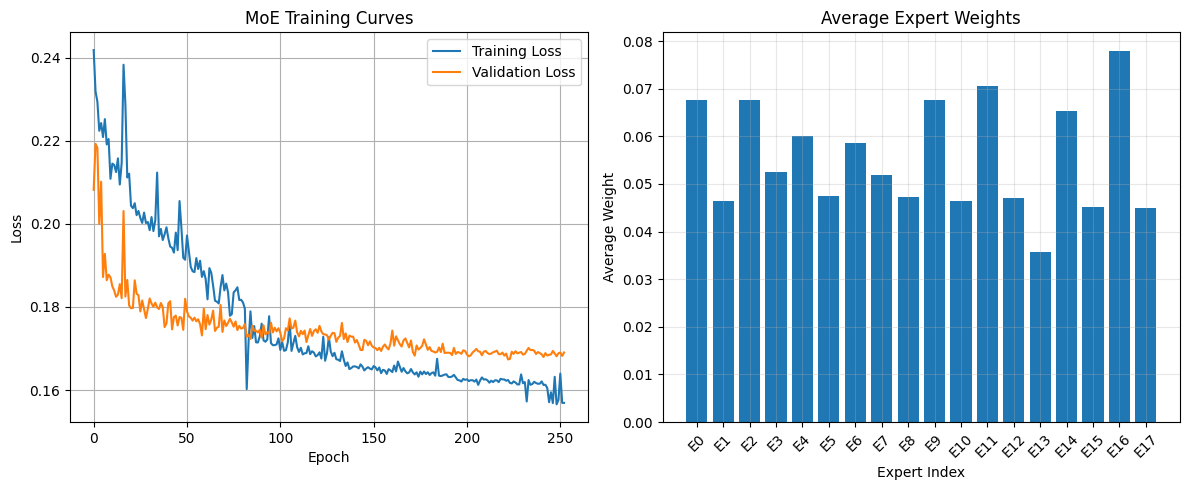

Results saved to 'predictions_m3_nbeats_stack_moe_with_moe_aggregation.csv'

Comparison on validation set:
Simple Average sMAPE: 0.2209
Simple Median sMAPE: 0.1392
MoE Model sMAPE: 0.1344
Improvement(over average): 39.13%
Improvement(over median): 3.40%

Comparison on teest set:
Simple Average sMAPE: 0.1361
Simple Median sMAPE: 0.1357
MoE Model sMAPE: 0.1404
Improvement(over average): -3.14%
Improvement(over median): -3.47%

Final Results Summary:
- Number of expert models: 18
- MoE model validation sMAPE: 0.1344
- Test predictions generated: 25704
- Most important expert: NBeatsStackMoe16 (weight: 0.0779)
- Least important expert: NBeatsStackMoe13 (weight: 0.0356)


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as sklearn_train_test_split
import torch.nn.functional as F

# Prepare the validation data for training MoE
print("Preparing data for MoE training...")

# Extract prediction columns (exclude unique_id, ds, and y)
pred_columns = [col for col in val_preds_on_ensemble_18_models.columns 
                if col.startswith('NBeatsStackMoe') and col != 'y']

print(f"Number of expert models: {len(pred_columns)}")

# Extract features (individual model predictions) and target (aggregated prediction)
X_val = val_preds_on_ensemble_18_models[pred_columns].values
y_val = val_preds_on_ensemble_18_models['y'].values

# For test set, we don't have the target, so we'll use it for final predictions
X_test = preds_on_ensemble_18[pred_columns].values
Y_test = y_test['y'].values

print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

# Split validation data into train/val for MoE training
X_train_moe, X_val_moe, y_train_moe, y_val_moe = sklearn_train_test_split(
    X_val, y_val, test_size=0.2, random_state=42
)

# Normalize the features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_moe_scaled = scaler_X.fit_transform(X_train_moe)
X_val_moe_scaled = scaler_X.transform(X_val_moe)
X_test_scaled = scaler_X.transform(X_test)
# Y_test_scaled = scaler_X.transform(Y_test)

y_train_moe_scaled = scaler_y.fit_transform(y_train_moe.reshape(-1, 1)).flatten()
y_val_moe_scaled = scaler_y.transform(y_val_moe.reshape(-1, 1)).flatten()

print(f"MoE Training data shape: {X_train_moe_scaled.shape}")
print(f"MoE Validation data shape: {X_val_moe_scaled.shape}")

# Define the Mixture of Experts model
class MixtureOfExpertsAggregator(nn.Module):
    def __init__(self, num_experts, hidden_dim=64, dropout_rate=0.1):
        super(MixtureOfExpertsAggregator, self).__init__()
        self.num_experts = num_experts
        
        # Simple MLP gating network that produces softmax weights
        self.gating_network = nn.Sequential(
            nn.Linear(num_experts, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, num_experts),
            nn.Softmax(dim=1)  # Softmax to ensure weights sum to 1
        )
        
    def forward(self, x):
        # Get gating weights from MLP
        gating_weights = self.gating_network(x)
        
        # Weighted sum: multiply each input prediction by its corresponding weight
        # x shape: (batch_size, num_experts)
        # gating_weights shape: (batch_size, num_experts)
        weighted_sum = torch.sum(gating_weights * x, dim=1, keepdim=True)
        
        return weighted_sum.squeeze(), gating_weights

# Dataset class for PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and dataloaders
train_dataset = TimeSeriesDataset(X_train_moe_scaled, y_train_moe_scaled)
val_dataset = TimeSeriesDataset(X_val_moe_scaled, y_val_moe_scaled)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize the model
num_experts = len(pred_columns)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = MixtureOfExpertsAggregator(num_experts, hidden_dim=256, dropout_rate=0.10)
model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output, gating_weights = model(data)
        loss = criterion(output, target)
        
        # Add regularization to encourage diverse gating
        entropy_reg = -torch.mean(torch.sum(gating_weights * torch.log(gating_weights + 1e-8), dim=1))
        total_loss_with_reg = loss - 0.01 * entropy_reg  # Encourage diversity
        
        total_loss_with_reg.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

# Training loop
print("Starting MoE training...")
num_epochs = 300
best_val_loss = float('inf')
patience_counter = 0
patience_limit = 30

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # print(f'Epoch {epoch + 1}/{num_epochs}')
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate_epoch(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_moe_model.pth')
    else:
        patience_counter += 1
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}')
    
    if patience_counter >= patience_limit:
        print(f'Early stopping at epoch {epoch}')
        break

# Load best model
model.load_state_dict(torch.load('best_moe_model.pth'))
print(f'Best validation loss: {best_val_loss:.6f}')

# Make predictions on the test set
def predict_moe_on_test(model, X_test_scaled, scaler_y, device, batch_size=1000):
    """
    Generate predictions and gating weights for the test set using the trained MoE model.

    Args:
        model: Trained MixtureOfExpertsAggregator model.
        X_test_scaled: Scaled test features (numpy array).
        scaler_y: Fitted StandardScaler for inverse transforming predictions.
        device: Torch device ('cuda' or 'cpu').
        batch_size: Batch size for inference.

    Returns:
        test_predictions_original: Inverse-transformed predictions (numpy array).
        test_gating_weights: Gating weights for each test sample (numpy array).
    """
    model.eval()
    test_predictions = []
    test_gating_weights = []

    with torch.no_grad():
        test_tensor = torch.FloatTensor(X_test_scaled).to(device)
        for i in range(0, len(test_tensor), batch_size):
            batch = test_tensor[i:i + batch_size]
            pred, gating = model(batch)
            test_predictions.extend(pred.cpu().numpy())
            test_gating_weights.extend(gating.cpu().numpy())

    test_predictions = np.array(test_predictions)
    test_gating_weights = np.array(test_gating_weights)
    test_predictions_original = scaler_y.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
    return test_predictions_original, test_gating_weights


# Use the function to get predictions and gating weights
test_predictions_original, test_gating_weights = predict_moe_on_test(
    model, X_test_scaled, scaler_y, device
)

val_predictions, val_gating_weights = predict_moe_on_test(
    model, X_val_moe_scaled, scaler_y, device
)

# Add MoE predictions to the test dataframe
preds_on_ensemble_18_moe = preds_on_ensemble_18.copy()
preds_on_ensemble_18_moe['moe_prediction'] = test_predictions_original

# noe on the test set
moe_smape_test = calculate_smape(
    y_test,
    preds_on_ensemble_18_moe,
    'moe_prediction'
)
print(f"MoE Model sMAPE on test set: {moe_smape_test:.4f}")

val_predictions, val_gating_weights = predict_moe_on_test(
    model, X_val_moe_scaled, scaler_y, device
)

moe_smape = calculate_smape(
    pd.DataFrame({'y': y_val_moe, 'unique_id': ['test'] * len(y_val_moe)}),
    val_predictions,
    'moe_prediction'
)

print(f"MoE Model sMAPE on validation set: {moe_smape:.4f}")


# Analyze gating weights to understand which experts are most important
avg_gating_weights = np.mean(test_gating_weights, axis=0)
expert_importance = dict(zip(pred_columns, avg_gating_weights))
expert_importance_sorted = sorted(expert_importance.items(), key=lambda x: x[1], reverse=True)

print("\nExpert Importance (Average Gating Weights):")
for expert, weight in expert_importance_sorted:
    print(f"{expert}: {weight:.4f}")

# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('MoE Training Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(range(len(avg_gating_weights)), avg_gating_weights)
plt.title('Average Expert Weights')
plt.xlabel('Expert Index')
plt.ylabel('Average Weight')
plt.xticks(range(len(avg_gating_weights)), [f'E{i}' for i in range(len(avg_gating_weights))], rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the results
preds_on_ensemble_18_moe.to_csv('predictions_m3_nbeats_stack_moe_with_moe_aggregation.csv', index=False)
print("Results saved to 'predictions_m3_nbeats_stack_moe_with_moe_aggregation.csv'")

# Compare simple average vs MoE prediction on validation set
simple_avg_val = np.mean(X_val, axis=1)
simple_avg_smape = calculate_smape(
    y_test,
    simple_avg_val,
    'simple_avg'
)

simple_median_val = np.median(X_val, axis=1)
simple_median_smape = calculate_smape(
    pd.DataFrame({'y': y_val, 'unique_id': ['test'] * len(y_val)}),
    simple_median_val,
    'simple_median'
)


print(f"\nComparison on validation set:")
print(f"Simple Average sMAPE: {simple_avg_smape:.4f}")
print(f"Simple Median sMAPE: {simple_median_smape:.4f}")
print(f"MoE Model sMAPE: {moe_smape:.4f}")
print(f"Improvement(over average): {((simple_avg_smape - moe_smape) / simple_avg_smape * 100):.2f}%")
print(f"Improvement(over median): {((simple_median_smape - moe_smape) / simple_median_smape * 100):.2f}%")


# Compare simple average vs MoE prediction on test set

preds_on_ensemble_18['simple_avg'] = preds_on_ensemble_18[pred_columns].mean(axis=1)
preds_on_ensemble_18['simple_median'] = preds_on_ensemble_18[pred_columns].median(axis=1)
simple_avg_smape = calculate_smape(
    y_test,
    preds_on_ensemble_18,
    'simple_avg'
)

simple_median_smape = calculate_smape(
    y_test,
    preds_on_ensemble_18,
    'simple_median'
)

print(f"\nComparison on teest set:")
print(f"Simple Average sMAPE: {simple_avg_smape:.4f}")
print(f"Simple Median sMAPE: {simple_median_smape:.4f}")
print(f"MoE Model sMAPE: {moe_smape_test:.4f}")
print(f"Improvement(over average): {((simple_avg_smape - moe_smape_test) / simple_avg_smape * 100):.2f}%")
print(f"Improvement(over median): {((simple_median_smape - moe_smape_test) / simple_median_smape * 100):.2f}%")


# Final predictions summary
print(f"\nFinal Results Summary:")
print(f"- Number of expert models: {num_experts}")
print(f"- MoE model validation sMAPE: {moe_smape:.4f}")
print(f"- Test predictions generated: {len(test_predictions_original)}")
print(f"- Most important expert: {expert_importance_sorted[0][0]} (weight: {expert_importance_sorted[0][1]:.4f})")
print(f"- Least important expert: {expert_importance_sorted[-1][0]} (weight: {expert_importance_sorted[-1][1]:.4f})")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split as sklearn_train_test_split
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List
import warnings
warnings.filterwarnings('ignore')

# ========== ENHANCED MODEL CLASSES ==========

class EnhancedMixtureOfExpertsAggregator(nn.Module):
    def __init__(self, num_experts, num_series=None, series_embed_dim=16, 
                 hidden_dim=128, dropout_rate=0.1, use_series_info=True,
                 aggregation_method='robust_weighted'):
        super(EnhancedMixtureOfExpertsAggregator, self).__init__()
        self.num_experts = num_experts
        self.use_series_info = use_series_info
        self.aggregation_method = aggregation_method
        
        # Series embedding if using series information
        if use_series_info and num_series:
            self.series_embedding = nn.Embedding(num_series, series_embed_dim)
            gating_input_dim = num_experts + series_embed_dim
        else:
            gating_input_dim = num_experts
            
        # Enhanced gating network with batch normalization
        self.gating_network = nn.Sequential(
            nn.Linear(gating_input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, num_experts)
        )
        
        # Additional networks for different aggregation methods
        if aggregation_method == 'weighted_median':
            self.final_activation = nn.Softmax(dim=1)
        elif aggregation_method == 'robust_weighted':
            self.final_activation = nn.Softmax(dim=1)
            self.outlier_detector = nn.Sequential(
                nn.Linear(num_experts, hidden_dim // 4),
                nn.ReLU(),
                nn.Linear(hidden_dim // 4, num_experts),
                nn.Sigmoid()
            )
        else:
            self.final_activation = nn.Softmax(dim=1)
            
    def weighted_median(self, values, weights):
        """Compute weighted median"""
        sorted_indices = torch.argsort(values, dim=1)
        sorted_values = torch.gather(values, 1, sorted_indices)
        sorted_weights = torch.gather(weights, 1, sorted_indices)
        
        cumsum_weights = torch.cumsum(sorted_weights, dim=1)
        total_weights = cumsum_weights[:, -1:]
        median_pos = total_weights * 0.5
        
        median_mask = cumsum_weights >= median_pos
        median_indices = torch.argmax(median_mask.float(), dim=1)
        
        median_values = torch.gather(sorted_values, 1, median_indices.unsqueeze(1))
        return median_values.squeeze(1)
    
    def forward(self, x, series_ids=None):
        # Prepare input for gating network
        if self.use_series_info and series_ids is not None:
            series_embed = self.series_embedding(series_ids)
            gating_input = torch.cat([x, series_embed], dim=1)
        else:
            gating_input = x
            
        # Get gating logits
        gating_logits = self.gating_network(gating_input)
        gating_weights = self.final_activation(gating_logits)
        
        if self.aggregation_method == 'weighted_sum':
            output = torch.sum(gating_weights * x, dim=1)
        elif self.aggregation_method == 'weighted_median':
            output = self.weighted_median(x, gating_weights)
        elif self.aggregation_method == 'robust_weighted':
            confidence_scores = self.outlier_detector(x)
            robust_weights = gating_weights * confidence_scores
            robust_weights = robust_weights / (torch.sum(robust_weights, dim=1, keepdim=True) + 1e-8)
            output = torch.sum(robust_weights * x, dim=1)
        else:
            output = torch.sum(gating_weights * x, dim=1)
            
        return output, gating_weights

class EnhancedTimeSeriesDataset(Dataset):
    def __init__(self, X, y, series_ids=None):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        self.series_ids = torch.LongTensor(series_ids) if series_ids is not None else None
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.series_ids is not None:
            return self.X[idx], self.y[idx], self.series_ids[idx]
        return self.X[idx], self.y[idx]

# ========== HELPER FUNCTIONS ==========

def prepare_enhanced_data(val_preds_df, test_preds_df, use_series_info=True):
    """Prepare data with optional series information encoding"""
    pred_columns = [col for col in val_preds_df.columns 
                    if col.startswith('NBeatsStackMoe') and col != 'y']
    
    X_val = val_preds_df[pred_columns].values
    y_val = val_preds_df['y'].values
    X_test = test_preds_df[pred_columns].values
    
    series_ids_val = None
    series_ids_test = None
    num_series = None
    label_encoder = None
    
    if use_series_info and 'unique_id' in val_preds_df.columns:
        label_encoder = LabelEncoder()
        all_series = pd.concat([val_preds_df['unique_id'], test_preds_df['unique_id']]).unique()
        label_encoder.fit(all_series)
        
        series_ids_val = label_encoder.transform(val_preds_df['unique_id'])
        series_ids_test = label_encoder.transform(test_preds_df['unique_id'])
        num_series = len(all_series)
        
        print(f"Number of unique series: {num_series}")
    
    return (X_val, y_val, X_test, series_ids_val, series_ids_test, 
            num_series, pred_columns, label_encoder)

def train_enhanced_epoch(model, train_loader, criterion, optimizer, device, use_series_info=True):
    model.train()
    total_loss = 0
    
    for batch_idx, batch in enumerate(train_loader):
        if use_series_info and len(batch) == 3:
            data, target, series_ids = batch
            data, target, series_ids = data.to(device), target.to(device), series_ids.to(device)
        else:
            data, target = batch[:2]
            data, target = data.to(device), target.to(device)
            series_ids = None
        
        optimizer.zero_grad()
        
        if use_series_info and series_ids is not None:
            output, gating_weights = model(data, series_ids)
        else:
            output, gating_weights = model(data)
            
        loss = criterion(output, target)
        
        # Enhanced regularization
        entropy_reg = -torch.mean(torch.sum(gating_weights * torch.log(gating_weights + 1e-8), dim=1))
        l2_reg = torch.mean(torch.sum(gating_weights ** 2, dim=1))
        sparsity_reg = torch.mean(torch.sum(torch.abs(gating_weights), dim=1))
        
        total_loss_with_reg = (loss + 
                              0.01 * entropy_reg - 
                              0.005 * l2_reg + 
                              0.001 * sparsity_reg)
        
        total_loss_with_reg.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate_enhanced_epoch(model, val_loader, criterion, device, use_series_info=True):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in val_loader:
            if use_series_info and len(batch) == 3:
                data, target, series_ids = batch
                data, target, series_ids = data.to(device), target.to(device), series_ids.to(device)
            else:
                data, target = batch[:2]
                data, target = data.to(device), target.to(device)
                series_ids = None
            
            if use_series_info and series_ids is not None:
                output, _ = model(data, series_ids)
            else:
                output, _ = model(data)
                
            loss = criterion(output, target)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

def predict_enhanced_moe(model, X_scaled, series_ids, scaler_y, device, 
                        use_series_info=True, batch_size=1000):
    """Enhanced prediction with series information"""
    model.eval()
    predictions = []
    gating_weights = []
    
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_scaled).to(device)
        
        if use_series_info and series_ids is not None:
            series_tensor = torch.LongTensor(series_ids).to(device)
        
        for i in range(0, len(X_tensor), batch_size):
            batch_X = X_tensor[i:i + batch_size]
            
            if use_series_info and series_ids is not None:
                batch_series = series_tensor[i:i + batch_size]
                pred, gating = model(batch_X, batch_series)
            else:
                pred, gating = model(batch_X)
                
            predictions.extend(pred.cpu().numpy())
            gating_weights.extend(gating.cpu().numpy())
    
    predictions = np.array(predictions)
    gating_weights = np.array(gating_weights)
    predictions_original = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()
    
    return predictions_original, gating_weights

# ========== MAIN TRAINING FUNCTION ==========

def train_enhanced_moe_complete(val_preds_df, test_preds_df, y_test_df, calculate_smape_func,
                               use_series_info=True, aggregation_method='robust_weighted',
                               num_models=3):  # Train ensemble of models
    """
    Complete enhanced MoE training pipeline
    """
    print("="*50)
    print("ENHANCED MoE TRAINING PIPELINE")
    print("="*50)
    
    # Prepare data
    print("Preparing enhanced data...")
    (X_val, y_val, X_test, series_ids_val, series_ids_test, 
     num_series, pred_columns, label_encoder) = prepare_enhanced_data(
        val_preds_df, test_preds_df, use_series_info)
    
    print(f"Number of expert models: {len(pred_columns)}")
    print(f"Validation data shape: {X_val.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Using series info: {use_series_info}")
    print(f"Aggregation method: {aggregation_method}")
    
    # Train ensemble of models
    ensemble_models = []
    ensemble_scalers_y = []
    ensemble_scalers_X = []
    all_test_predictions = []
    
    for model_idx in range(num_models):
        print(f"\n--- Training Model {model_idx + 1}/{num_models} ---")
        
        # Split for training (different random state for each model)
        random_state = 42 + model_idx
        
        if use_series_info and series_ids_val is not None:
            # Try stratified split, fall back to regular if not possible
            try:
                X_train_moe, X_val_moe, y_train_moe, y_val_moe, series_train, series_val = sklearn_train_test_split(
                    X_val, y_val, series_ids_val, test_size=0.2, random_state=random_state, stratify=series_ids_val
                )
            except:
                print("Stratified split failed, using regular split")
                X_train_moe, X_val_moe, y_train_moe, y_val_moe, series_train, series_val = sklearn_train_test_split(
                    X_val, y_val, series_ids_val, test_size=0.2, random_state=random_state
                )
        else:
            X_train_moe, X_val_moe, y_train_moe, y_val_moe = sklearn_train_test_split(
                X_val, y_val, test_size=0.2, random_state=random_state
            )
            series_train = series_val = None
        
        # Scale features and targets
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        
        X_train_moe_scaled = scaler_X.fit_transform(X_train_moe)
        X_val_moe_scaled = scaler_X.transform(X_val_moe)
        X_test_scaled = scaler_X.transform(X_test)
        
        y_train_moe_scaled = scaler_y.fit_transform(y_train_moe.reshape(-1, 1)).flatten()
        y_val_moe_scaled = scaler_y.transform(y_val_moe.reshape(-1, 1)).flatten()
        
        # Create datasets
        train_dataset = EnhancedTimeSeriesDataset(X_train_moe_scaled, y_train_moe_scaled, series_train)
        val_dataset = EnhancedTimeSeriesDataset(X_val_moe_scaled, y_val_moe_scaled, series_val)
        
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)
        
        # Initialize model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        model = EnhancedMixtureOfExpertsAggregator(
            num_experts=len(pred_columns),
            num_series=num_series,
            series_embed_dim=32 if num_series else 16,
            hidden_dim=256,
            dropout_rate=0.1,
            use_series_info=use_series_info,
            aggregation_method=aggregation_method
        ).to(device)
        
        # Training setup
        criterion = nn.MSELoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2)
        
        # Training loop
        best_val_loss = float('inf')
        patience_counter = 0
        train_losses = []
        val_losses = []
        
        print("Starting training...")
        num_epochs = 300
        
        for epoch in range(num_epochs):
            train_loss = train_enhanced_epoch(model, train_loader, criterion, optimizer, 
                                            device, use_series_info)
            val_loss = validate_enhanced_epoch(model, val_loader, criterion, device, use_series_info)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            scheduler.step()
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), f'best_enhanced_moe_model_{model_idx}.pth')
            else:
                patience_counter += 1
            
            if epoch % 25 == 0:
                print(f'Epoch {epoch:03d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}')
            
            if patience_counter >= 40:
                print(f'Early stopping at epoch {epoch}')
                break
        
        # Load best model and make predictions
        model.load_state_dict(torch.load(f'best_enhanced_moe_model_{model_idx}.pth'))
        print(f'Model {model_idx + 1} - Best validation loss: {best_val_loss:.6f}')
        
        # Store model and scalers for ensemble
        ensemble_models.append(model)
        ensemble_scalers_y.append(scaler_y)
        ensemble_scalers_X.append(scaler_X)
        
        # Get predictions from this model
        test_predictions, test_gating_weights = predict_enhanced_moe(
            model, X_test_scaled, series_ids_test, scaler_y, device, use_series_info
        )
        all_test_predictions.append(test_predictions)
    
    # Ensemble predictions (median of all models)
    print("\n--- Creating Ensemble Predictions ---")
    ensemble_test_predictions = np.median(np.array(all_test_predictions), axis=0)
    
    # Evaluate ensemble
    test_preds_df_enhanced = test_preds_df.copy()
    test_preds_df_enhanced['enhanced_moe_prediction'] = ensemble_test_predictions
    
    enhanced_moe_smape_test = calculate_smape_func(
        y_test_df,
        test_preds_df_enhanced,
        'enhanced_moe_prediction'
    )
    
    print(f"Enhanced MoE Ensemble sMAPE on test set: {enhanced_moe_smape_test:.4f}")
    
    # Compare with simple baselines
    print("\n--- Comparison with Baselines ---")
    
    # Simple average and median
    test_preds_df_enhanced['simple_avg'] = test_preds_df[pred_columns].mean(axis=1)
    test_preds_df_enhanced['simple_median'] = test_preds_df[pred_columns].median(axis=1)
    
    simple_avg_smape = calculate_smape_func(y_test_df, test_preds_df_enhanced, 'simple_avg')
    simple_median_smape = calculate_smape_func(y_test_df, test_preds_df_enhanced, 'simple_median')
    
    print(f"Simple Average sMAPE: {simple_avg_smape:.4f}")
    print(f"Simple Median sMAPE: {simple_median_smape:.4f}")
    print(f"Enhanced MoE Ensemble sMAPE: {enhanced_moe_smape_test:.4f}")
    print(f"Improvement over Average: {((simple_avg_smape - enhanced_moe_smape_test) / simple_avg_smape * 100):.2f}%")
    print(f"Improvement over Median: {((simple_median_smape - enhanced_moe_smape_test) / simple_median_smape * 100):.2f}%")
    
    # Analyze expert importance (using first model)
    final_test_predictions, final_gating_weights = predict_enhanced_moe(
        ensemble_models[0], ensemble_scalers_X[0].transform(X_test), 
        series_ids_test, ensemble_scalers_y[0], device, use_series_info
    )
    
    avg_gating_weights = np.mean(final_gating_weights, axis=0)
    expert_importance = dict(zip(pred_columns, avg_gating_weights))
    expert_importance_sorted = sorted(expert_importance.items(), key=lambda x: x[1], reverse=True)
    
    print("\n--- Expert Importance (Average Gating Weights) ---")
    for expert, weight in expert_importance_sorted[:10]:  # Top 10
        print(f"{expert}: {weight:.4f}")
    
    # Save results
    output_filename = f'enhanced_moe_predictions_{aggregation_method}_{"with_series" if use_series_info else "no_series"}.csv'
    test_preds_df_enhanced.to_csv(output_filename, index=False)
    print(f"\nResults saved to: {output_filename}")
    
    return {
        'ensemble_models': ensemble_models,
        'ensemble_scalers_X': ensemble_scalers_X,
        'ensemble_scalers_y': ensemble_scalers_y,
        'test_predictions': ensemble_test_predictions,
        'test_smape': enhanced_moe_smape_test,
        'expert_importance': expert_importance_sorted,
        'predictions_df': test_preds_df_enhanced
    }

# ========== EASY-TO-USE WRAPPER FUNCTION ==========

def run_enhanced_moe_training(val_preds_on_ensemble_18_models, preds_on_ensemble_18, 
                             y_test, calculate_smape):
    """
    Easy wrapper function that matches your existing variable names
    """
    print("Starting Enhanced MoE Training with your data...")
    
    # Test different configurations
    configurations = [
        {'use_series_info': True, 'aggregation_method': 'robust_weighted'},
        {'use_series_info': True, 'aggregation_method': 'weighted_median'},
        {'use_series_info': False, 'aggregation_method': 'robust_weighted'},
    ]
    
    best_config = None
    best_smape = float('inf')
    all_results = {}
    
    for i, config in enumerate(configurations):
        print(f"\n{'='*60}")
        print(f"CONFIGURATION {i+1}: {config}")
        print(f"{'='*60}")
        
        try:
            results = train_enhanced_moe_complete(
                val_preds_on_ensemble_18_models, 
                preds_on_ensemble_18, 
                y_test, 
                calculate_smape,
                **config,
                num_models=2  # Reduced for faster testing
            )
            
            all_results[f"config_{i+1}"] = results
            
            if results['test_smape'] < best_smape:
                best_smape = results['test_smape']
                best_config = config
                
        except Exception as e:
            print(f"Configuration {i+1} failed with error: {e}")
            continue
    
    print(f"\n{'='*60}")
    print("FINAL SUMMARY")
    print(f"{'='*60}")
    print(f"Best configuration: {best_config}")
    print(f"Best sMAPE: {best_smape:.4f}")
    
    return all_results

# ========== USAGE INSTRUCTIONS ==========
print("""
To run the enhanced MoE with your existing data, simply call:

results = run_enhanced_moe_training(
    val_preds_on_ensemble_18_models,  # Your validation predictions DataFrame
    preds_on_ensemble_18,             # Your test predictions DataFrame  
    y_test,                           # Your test targets DataFrame
    calculate_smape                   # Your sMAPE calculation function
)

This will automatically:
1. Test different configurations (with/without series info, different aggregation methods)
2. Train ensemble models for each configuration
3. Compare results and return the best performing setup
4. Save all predictions to CSV files

The function expects your DataFrames to have:
- Prediction columns starting with 'NBeatsStackMoe'
- 'y' column for targets (in validation data)
- 'unique_id' column for series identification
""")

results = run_enhanced_moe_training(
    val_preds_on_ensemble_18_models,  # Your validation predictions DataFrame
    preds_on_ensemble_18,             # Your test predictions DataFrame  
    y_test,                           # Your test targets DataFrame
    calculate_smape                   # Your sMAPE calculation function
)


To run the Top-K MoE with your existing data, simply call:

results = run_topk_moe_training(
    val_preds_on_ensemble_18_models,  # Your validation predictions DataFrame
    preds_on_ensemble_18,             # Your test predictions DataFrame  
    y_test,                           # Your test targets DataFrame
    calculate_smape,                  # Your sMAPE calculation function
    top_k_values=[8, 10, 12]         # Different k values to test
)

Key improvements in Top-K MoE:
1. Selects top-k experts instead of using all experts
2. Reduces noise from poor-performing experts
3. Implements load balancing to encourage expert diversity
4. Provides detailed analysis of expert selection patterns
5. Tests multiple k values to find optimal sparsity

The function will automatically:
1. Test different k values (8, 10, 12 by default)
      
Starting Top-K MoE Training with your data...

CONFIGURATION 1: {'use_series_info': True, 'aggregation_method': 'robust_weighted', 'top_k': 8}
TOP-K MoE 